In [463]:
%matplotlib notebook

In [464]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy as ap
from astropy.io import fits
from astropy.table import Table
import specreduce
from specreduce.calibration_data import AtmosphericTransmission, SUPPORTED_EXTINCTION_MODELS
from scipy import integrate
import pandas as pd

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

### Austen Fourkas HW1

The point of this assignment is to:
- get comfortable with photon energy, frequency, and wavelength - calculate power and luminosity
- know now to convert magnitudes, fluxes, photon counts.
- start basic Python scripts and plotting

# Q1. Make plot of the electromagnetic spectrum using Python. (30 pts)
- Your plot should have multiple x-axes - one for wavelength (in meters), one for frequency (in Hz), one for energy (in eV)
    (hint: `gridspec` or `subplots` in general can be used to do this. See if you can find something useful here: https://matplotlib.org/stable/gallery/index) (10 pts)
- axes should be lograthmic, and each of these axes should have ticklabels that are exponential above or below (5 pts)
- the wavelength axes should also have more conventional SI units for km, mm, micron, nm, Angstrom, and picometer labelled (5 pts)
- label each region of the EM spectrum (10 pts)

 Something like this: 

<img src="https://aktinovolia.com/wp-content/uploads/aktinovolia.com-radiation-chart-electromagnetic-spectrum-rf-em-spectrum-rf-electromagnetic-3-.jpg">

or (except you should have energy too) 

<img src="https://multiphaseism.wordpress.com/wp-content/uploads/2013/05/electromagnetic_spectrum.jpg">

# Remember to save your script. Stay organized. You will be reusing code.

You are encouraged to add your own flourishes to the plot.
Joseph is empowered to give out 5 points as he sees fit for aesthetics. 

Keep this plot handy. You should be able to intuitively convert between these values in your head. 

<IPython.core.display.Javascript object>


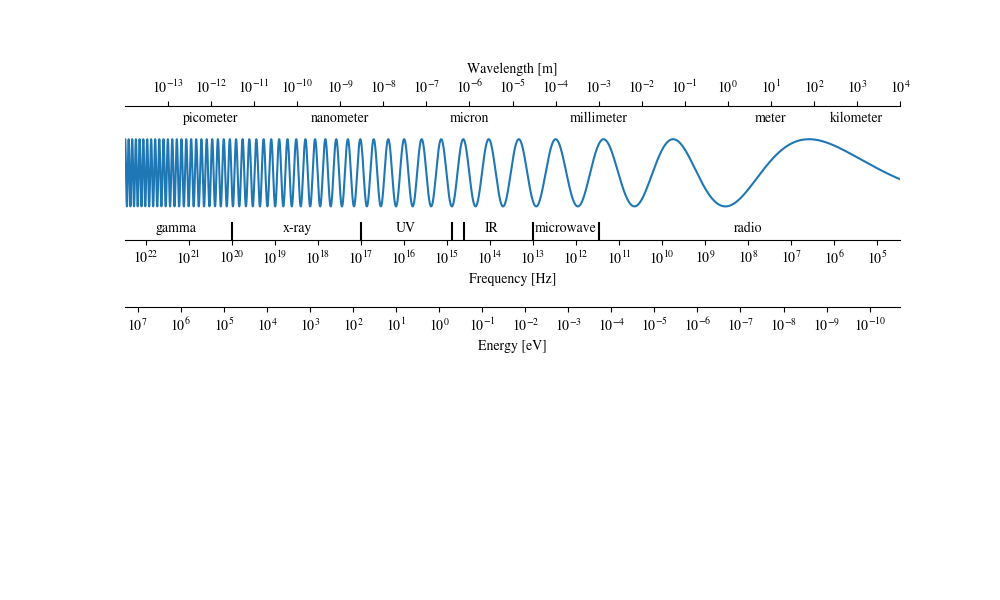

In [465]:
## text params
mpl.rcParams["font.family"] = "STIXGeneral"

## constants
c = 3e8 # m/s
h = 6.582e-16 # ev.s

## scale creation
lambda_scale = np.logspace(start=-14, stop=4, num=10000) # Meters
nu_scale = c / lambda_scale # Hz
energy_scale = h * nu_scale # eV

## dummy arrays
t_array = np.linspace(0,1,10000)
dt = t_array[1]-t_array[0]

# wave creation
def wave(freq1, freq2, t, n):
    sin_array = []
    f_space = np.logspace(freq1, freq2, n)
    t_space = np.linspace(0,t,n)
    dt = t_space[1] - t_space[0]
    for i in range(n):
        d_f = f_space[-1]-f_space[0]
        phi = d_f * 2*np.pi * dt
        sin_arg = (f_space[i]*t_space[i]) - phi
        sin_val = np.sin(sin_arg)
        sin_array = np.append(sin_array, sin_val)
    return sin_array


wave_vals = wave(1,2.5,1,10000)

## plotting
fig=plt.figure(figsize=(10,6))

# axes
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twiny()

# data
ax1.plot(nu_scale, np.flip(wave_vals))

# axes
ax1.set_xscale("log")
ax2.set_xscale("log")
ax3.set_xscale("log")

# add space for axes
fig.subplots_adjust(bottom=0.6)

# remove spines
ax1.spines[['top', 'left', 'right']].set_visible(False)
ax2.spines[['bottom', 'left', 'right']].set_visible(False)
ax3.spines[['top', 'left', 'right']].set_visible(False)

# move axes

# ax2
ax2.xaxis.set_ticks_position("top")
ax2.xaxis.set_label_position("top")
ax2.spines["top"].set_position(("axes", 0.8))

# # ax3
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")
ax3.spines["bottom"].set_position(("axes", -0.4))

# tick labels
# y
ax1.get_yaxis().set_visible(False)

# x 

xtick1_array = np.logspace(4,22,19)
ax1.set_xticks(xtick1_array)

xtick2_array = np.logspace(-13,4,18)
ax2.set_xticks(xtick2_array)

xtick3_array = np.logspace(-11,7,19)
ax3.set_xticks(xtick3_array)


# axis labels
ax1.set_xlabel("Frequency [Hz]")
ax2.set_xlabel("Wavelength [m]")
ax3.set_xlabel("Energy [eV]")

# limit
ax1.set_xlim([nu_scale[0], nu_scale[-1]])
ax2.set_xlim([lambda_scale[0], lambda_scale[-1]])
ax3.set_xlim([energy_scale[0], energy_scale[-1]])
ax1.set_ylim([-2,3])

## text
ax1.text(2e21,-1.75,"gamma",horizontalalignment="center")
ax1.text(3e18,-1.75,"x-ray",horizontalalignment="center")
ax1.text(9e15,-1.75,"UV",horizontalalignment="center")
ax1.text(9e13,-1.75,"IR",horizontalalignment="center")
ax1.text(1.765e12,-1.75,"microwave",horizontalalignment="center")
ax1.text(1e8,-1.75,"radio",horizontalalignment="center")

ax2.text(1e3,1.5,"kilometer",horizontalalignment="center")
ax2.text(1e1,1.5,"meter",horizontalalignment="center")
ax2.text(1e-3,1.5,"millimeter",horizontalalignment="center")
ax2.text(1e-6,1.5,"micron",horizontalalignment="center")
ax2.text(1e-9,1.5,"nanometer",horizontalalignment="center")
ax2.text(1e-12,1.5,"picometer",horizontalalignment="center")

## vlines
ax1.axvline(1e20, 0,0.1, c="k")
ax1.axvline(1e17, 0,0.1, c="k")
ax1.axvline(7.5e14, 0,0.1, c="k")
ax1.axvline(4e14, 0,0.1, c="k")
ax1.axvline(1e13, 0,0.1, c="k")
ax1.axvline(3e11, 0,0.1, c="k")



#
plt.show()



# Q2. Dealing with Data from Multiple Sources - adding passbands and atmospheric transmission (30 pts)

### 2.1
Get the Optical Atmospheric Transmission using the `specreduce` package
    `pip install specreduce`
    https://specreduce.readthedocs.io/en/latest/extinction.html

Note that the optical transmission curves do not include the effect of molecules as the website tells you.
Follow their instructions to add 2.3mm of Preciptiable Water Vapr at an Airmass of 1.0 to the optical transmission. 

Get NIR and MIR transmission curves from here (we're not using MIR this week, but you'll use this code next HW as well)
	http://www.gemini.edu/sciops/telescopes-and-sites/observing-condition-constraints/ir-transmission-spectra
(Cerro Pachon, 2.3mm of Precipitable Water Vapor, Airmass 1.0)


### 2.2
Get the LSST Filter Transmissions (ugrizy, filter only) from here:
http://svo2.cab.inta-csic.es/theory/fps3/index.php?mode=browse

and the IRTF (\[JHK\]_MK, filter only) transmissions from here:
https://irtfweb.ifa.hawaii.edu/~nsfcam2/Filter_Profiles.html

## !Please note that the filter tranmissions are determined by counting photons, not measuing energy! 

### 2.3

Finally, get the SEDs of three stars from CALSPEC:
https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs/calspec
and for the actual data:
https://archive.stsci.edu/hlsps/reference-atlases/cdbs/current_calspec/

(There is no M5V but there is a M3.5V star - BD-11 3759)


Finally, reconstruct a plot like this (set the wavelength ranges appropriately for the filters I've listed)
<img src="https://www.researchgate.net/profile/C-Chiosi/publication/1925441/figure/fig1/AS:339731901632519@1458009805844/The-filter-sets-used-in-the-present-work-From-top-to-bottom-we-show-the-filter-detector.png">

except replace the middle panel with the atmospheric transmission from your interpolator.

Something like this for the atmosphere plot (but until the wavelength you need): 
<img src="https://www.researchgate.net/profile/Joseph-Shaw-3/publication/260940640/figure/fig3/AS:296902361927680@1447798447054/Atmospheric-transmittance-versus-wavelength-calculated-with-Modtran5-for-a-zenith.png">

In [466]:
## DATA LOADING BLOCK

## PWV data
trans_default = AtmosphericTransmission()

trans_15_path = "Transmission/atm_transmission_secz1.5_1.6mm.dat"
trans_15_data = np.loadtxt(trans_15_path)

PWV_path = "Transmission/PWV_data.txt"
PWV_data = np.loadtxt(PWV_path, delimiter=",")

## NIR + MIR data
NIR_path = "Transmission/NIR_data.txt"
MIR_path = "Transmission/MIR_data.txt"

NIR_data = np.loadtxt(NIR_path)
MIR_data = np.loadtxt(MIR_path)

## LSST filters
LSST_g_file = "LSST/LSST_LSST.g_filter.dat"
LSST_i_file = "LSST/LSST_LSST.i_filter.dat"
LSST_r_file = "LSST/LSST_LSST.r_filter.dat"
LSST_u_file = "LSST/LSST_LSST.u_filter.dat"
LSST_y_file = "LSST/LSST_LSST.y_filter.dat"
LSST_z_file = "LSST/LSST_LSST.z_filter.dat"

g_data = np.loadtxt(LSST_g_file)
i_data = np.loadtxt(LSST_i_file)
r_data = np.loadtxt(LSST_r_file)
u_data = np.loadtxt(LSST_u_file)
y_data = np.loadtxt(LSST_y_file)
z_data = np.loadtxt(LSST_z_file)

## IRAF filters
IRAF_J_file = "MK/J_MK_data.txt"
IRAF_K_file = "MK/K_MK_data.txt"
IRAF_H_file = "MK/H_MK_data.txt"

J_data = np.loadtxt(IRAF_J_file)
K_data = np.loadtxt(IRAF_K_file)
H_data = np.loadtxt(IRAF_H_file)

## SED data
vega_path = "SED/alpha_lyr_stis_011.fits"
vega_import = fits.open(vega_path)
vega_data = Table(vega_import[1].data)

sun_path = "SED/sun_reference_stis_002.fits"
sun_import = fits.open(sun_path)
sun_data = Table(sun_import[1].data)

bd11_path = "SED/bd11d3759_stis_003.fits"
bd11_import = fits.open(bd11_path)
bd11_data = Table(bd11_import[1].data)

<IPython.core.display.Javascript object>


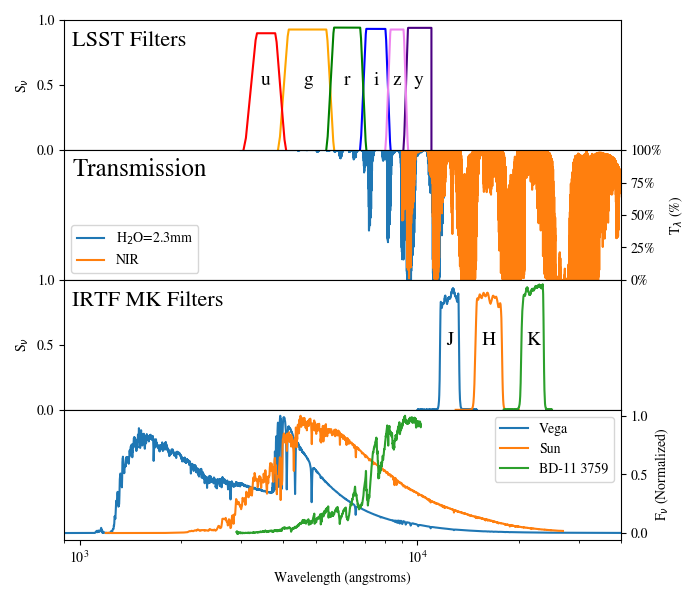

In [467]:
## plotting 

# figure
fig = plt.figure(figsize=(7,6)) 
gspec = fig.add_gridspec(4,hspace=0)
axs = gspec.subplots(sharex=True, sharey=False)
ax1=axs[0]
ax2=axs[1]
ax3=axs[2]
ax4=axs[3]

# ax1 data
ax1.plot(g_data[:,0], g_data[:,1], c="orange")
ax1.plot(i_data[:,0], i_data[:,1], c="blue")
ax1.plot(r_data[:,0], r_data[:,1], c="green")
ax1.plot(u_data[:,0], u_data[:,1], c="red")
ax1.plot(y_data[:,0], y_data[:,1], c="indigo")
ax1.plot(z_data[:,0], z_data[:,1], c="violet")

# ax1 scale
ax1.set_xscale("log")

# ax1 limits
ax1.set_ylim(bottom=0)
ax1.set_xlim([900,4e4])

# ax1 labels
ax1.set_xlabel(r"Wavelength $(\AA)$")
ax1.set_yticks([0, 0.5, 1])
ax1.set_ylabel(r"S$_{\nu}$")

# ax1 text
ax1.text(4746, 0.5, "g", horizontalalignment="center", fontsize=14)
ax1.text(7535, 0.5, "i", horizontalalignment="center", fontsize=14)
ax1.text(6201, 0.5, "r", horizontalalignment="center", fontsize=14)
ax1.text(3562, 0.5, "u", horizontalalignment="center", fontsize=14)
ax1.text(10103, 0.5, "y", horizontalalignment="center", fontsize=14)
ax1.text(8701, 0.5, "z", horizontalalignment="center", fontsize=14)
ax1.text(950, 0.8, "LSST Filters", horizontalalignment="left", fontsize=16)

# ax2 data
ax2.plot(PWV_data[:,0]*1e4, PWV_data[:,1]/np.amax(PWV_data[:,1]), label=r"H$_{2}$O=2.3mm")
ax2.plot(NIR_data[:,0]*1e4, NIR_data[:,1]/np.amax(NIR_data[:,1]), label="NIR")

        
# ax2 scale
ax2.set_xscale("log")
ax2.sharex(ax1)

# ax2 limits
ax2.set_ylim(bottom=0, top=1)

# ax2 labels
ax2.legend(loc=3)
ax2.set_yticks([0,0.25,0.5,0.75,1])
ax2.set_yticklabels(["0%", "25%", "50%", "75%", "100%"])
ax2.set_ylabel(r"T$_{\lambda}$ (%)")
ax2.yaxis.set_label_position("right")

# ax2 text
ax2.text(950,0.8, "Transmission", horizontalalignment="left", fontsize=18)

# ax2 ticks
ax2.yaxis.set_ticks_position("right")

# ax3 data
ax3.plot(J_data[:,0]*1e4, J_data[:,1]/100)
ax3.plot(H_data[:,0]*1e4, H_data[:,1]/100)
ax3.plot(K_data[:,0]*1e4, K_data[:,1]/100)

# ax3 limits
ax3.set_ylim(bottom=0, top=1)

# ax3 scale
ax3.set_xscale("log")
ax3.sharex(ax1)

# ax3 labels
ax3.set_yticks([0, 0.5, 1])
ax3.set_ylabel(r"S$_{\nu}$")

# ax3 text
ax3.text(12474, 0.5, "J", horizontalalignment="center", fontsize=14)
ax3.text(16275, 0.5, "H", horizontalalignment="center", fontsize=14)
ax3.text(21983, 0.5, "K", horizontalalignment="center", fontsize=14)
ax3.text(950, 0.8, "IRTF MK Filters", horizontalalignment="left", fontsize=16)

# ax4 data
ax4.plot(vega_data["WAVELENGTH"], vega_data["FLUX"]/np.amax(vega_data["FLUX"]), label="Vega")
ax4.plot(sun_data["WAVELENGTH"], sun_data["FLUX"]/np.amax(sun_data["FLUX"]), label="Sun")
ax4.plot(bd11_data["WAVELENGTH"], bd11_data["FLUX"]/np.amax(bd11_data["FLUX"]), label="BD-11 3759")

# ax 4 scale
ax4.set_xscale("log")
ax4.sharex(ax1)

# ax4 labels
ax4.set_xlabel(r"Wavelength (angstroms)")
ax4.set_ylabel(r"F$_{\nu}$ (Normalized)")
ax4.yaxis.set_label_position("right")

# ax4 limits
#ax4.set_ylim([0,1.05])

# ax4 ticks
ax4.yaxis.set_ticks_position("right")

# ax4 legend
ax4.legend(loc=1)

# plot
plt.tight_layout()
plt.show()


# Q3. Combine the filter transmission and your atmosphere transmission - we'll assume the mirror and CCDs are perfect over the entire wavelength range. Implement the integrals for flux and magnitude discussed in Lecture 3 as python code. (40 pts)

- You'll have to do something to `interpolate` measurements continuously across the full wavelength range you have across Optical to NIR (you can ignore the MIR file for now, but you'll want it next week)
- Make sure the units are consistent for both wavelength and transmission before you write your interpolator or address differences in some other way 
- You'll need to make sure your interpolator can match the wavelength spacing of the SEDs in Q2
- Rememeber that the intergrals intclude the transmission $T(\lambda)$, which is not normalized properly, so make sure to normalize your integral appropriately
- Normalize the synthetic flux in two ways
    1. such as Vega has magnitude 0 in each band.
    2. such that a synthetic AB source has magnitude 0 in each band

Report the magitudes of the Sun and BD-11 3759 in the Vega and AB system, and the AB magnitudes of Vega in a table (columns = passbands, rows = star/system)

- 15 pts each for the Sun and BD-11 3759 (2 pts for the six optical bands, 1 pt each for JHK) 
- 10 pts for the AB mags of Vega (yes, I know there are 9 bands, not 10, but you can have the one extra)

In [468]:
## DATA LOADING BLOCK

## wavelength data (angstroms)

# atmospheric transmission
td_x = ext_default.spectral_axis.value*1e4
td_15_x = trans_15_data[:,0]*1e4
PWV_x = PWV_data[:,0]*1e4
NIR_x = NIR_data[:,0]*1e4

# filters
u_x = u_data[:,0]
g_x = g_data[:,0]
r_x = r_data[:,0]
i_x = i_data[:,0]
z_x = z_data[:,0]
y_x = y_data[:,0]

J_x = J_data[:,0]*1e4
H_x = H_data[:,0]*1e4
K_x = K_data[:,0]*1e4

# SEDs
vega_x = vega_data["WAVELENGTH"]
sun_x = sun_data["WAVELENGTH"]
bd11_x = bd11_data["WAVELENGTH"]

## transmission/sensitivity/flux data

# atmospheric transmission
td_y = ext_default.transmission.value
td_15_y = trans_15_data[:,1]
PWV_y = PWV_data[:,1] / np.amax(PWV_data[:,1])
NIR_y = NIR_data[:,1] / np.amax(NIR_data[:,1])

# filters
u_y = u_data[:,1]
g_y = g_data[:,1]
r_y = r_data[:,1]
i_y = i_data[:,1]
z_y = z_data[:,1]
y_y = y_data[:,1]

J_y = J_data[:,1]
H_y = H_data[:,1]
K_y = K_data[:,1]

# SEDs
vega_y = vega_data["FLUX"]
sun_y = sun_data["FLUX"]
bd11_y = bd11_data["FLUX"]


In [469]:
## AB converter
def AB_conv(wavelength):
    c = 3e18
    nu = c/wavelength
    Fnu = 3.631e-20
    Fl = Fnu * (nu**2/c)
    return(Fl)

## interpolator

# response functions (LSST)
def filter_interp(filters_x, filters_y, trans_x, trans_y):
    filter_mult = []
    for i in range(len(filters_x)):
        trans_array = np.interp(trans_x, filters_x[i], filters_y[i])
        trans_mult = trans_array * trans_y
        filter_mult.append(trans_mult)
    return filter_mult

LSST_x_array = [u_x, g_x, r_x, i_x, z_x, y_x]
LSST_y_array = [u_y, g_y, r_y, i_y, z_y, y_y]
LSST_responses = filter_interp(LSST_x_array, LSST_y_array, PWV_x, PWV_y)

def SED_interp(response_x, response_y, SED_x, SED_y):
    SED_mult = []
    for i in range(len(response_y)):
        response_array = np.interp(SED_x, response_x, response_y[i])
        SED_mult.append(response_array)
    return SED_mult

# vega interp
vega_LSST_interp = SED_interp(PWV_x, LSST_responses, vega_x, vega_y)

# sun interp
sun_LSST_interp = SED_interp(PWV_x, LSST_responses, sun_x, sun_y)

# bd11 interp
bd11_LSST_interp = SED_interp(PWV_x, LSST_responses, bd11_x, bd11_y)


# response functions MK
MK_x_array = [J_x, H_x, K_x]
MK_y_array = [J_y, H_y, K_y]
MK_responses = filter_interp(MK_x_array, MK_y_array, NIR_x, NIR_y)

# vega interp
vega_MK_interp = SED_interp(NIR_x, MK_responses, vega_x, vega_y)

# sun interp
sun_MK_interp = SED_interp(NIR_x, MK_responses, sun_x, sun_y)

# bd11 interp
bd11_MK_interp = SED_interp(NIR_x, MK_responses, bd11_x, bd11_y)

## AB arrays
AB_vega_range = AB_conv(vega_x)
AB_sun_range = AB_conv(sun_x)
AB_bd11_range = AB_conv(bd11_x)

In [470]:
## integration function
def flux_int(wavelength, flux, response):
    dl = wavelength[1] - wavelength[0]
    int_value = wavelength*flux*response
    int_final = integrate.simpson(x=wavelength, y=int_value, dx=dl)
    return int_final

## magnitude calculations - LSST
sun_LSST_flux = np.zeros(6)
vega_LSST_flux = np.zeros(6)
bd11_LSST_flux = np.zeros(6)

sun_LSST_AB_flux = np.zeros(6)
vega_LSST_AB_flux = np.zeros(6)
bd11_LSST_AB_flux = np.zeros(6)

for i in range(6):
    sun_flux = flux_int(sun_x, sun_y, sun_LSST_interp[i])
    bd11_flux = flux_int(bd11_x, bd11_y, bd11_LSST_interp[i])
    vega_flux = flux_int(vega_x, vega_y, vega_LSST_interp[i])
    
    AB_sun = flux_int(sun_x, AB_sun_range, sun_LSST_interp[i])
    AB_bd11 = flux_int(bd11_x, AB_bd11_range, bd11_LSST_interp[i])
    AB_vega = flux_int(vega_x, AB_vega_range, vega_LSST_interp[i])
    
    sun_LSST_flux[i] = sun_flux
    bd11_LSST_flux[i] = bd11_flux
    vega_LSST_flux[i] = vega_flux
    
    sun_LSST_AB_flux[i] = AB_sun
    bd11_LSST_AB_flux[i] = AB_bd11
    vega_LSST_AB_flux[i] = AB_vega

## magnitude calculations - MK
sun_MK_flux = np.zeros(3)
vega_MK_flux = np.zeros(3)
bd11_MK_flux = np.zeros(3)

sun_MK_AB_flux = np.zeros(3)
vega_MK_AB_flux = np.zeros(3)
bd11_MK_AB_flux = np.zeros(3)

for i in range(3):
    sun_flux = flux_int(sun_x, sun_y, sun_MK_interp[i])
    bd11_flux = flux_int(bd11_x, bd11_y, bd11_MK_interp[i])
    vega_flux = flux_int(vega_x, vega_y, vega_MK_interp[i])
    
    AB_sun = flux_int(sun_x, AB_sun_range, sun_MK_interp[i])
    AB_bd11 = flux_int(bd11_x, AB_bd11_range, bd11_MK_interp[i])
    AB_vega = flux_int(vega_x, AB_vega_range, vega_MK_interp[i])
    
    sun_MK_flux[i] = sun_flux
    bd11_MK_flux[i] = bd11_flux
    vega_MK_flux[i] = vega_flux
    
    sun_MK_AB_flux[i] = AB_sun
    bd11_MK_AB_flux[i] = AB_bd11
    vega_MK_AB_flux[i] = AB_vega


# LSST vega
sun_mag_LSST = -2.5*np.log10(sun_LSST_flux/vega_LSST_flux)
bd11_mag_LSST = -2.5*np.log10(bd11_LSST_flux/vega_LSST_flux)

# LSST AB
sun_AB_mag_LSST = -2.5*np.log10(sun_LSST_flux/sun_LSST_AB_flux)
bd11_AB_mag_LSST = -2.5*np.log10(bd11_LSST_flux/bd11_LSST_AB_flux)
vega_AB_mag_LSST = -2.5*np.log10(vega_LSST_flux/vega_LSST_AB_flux)

# MK vega
sun_mag_MK = -2.5*np.log10(sun_MK_flux/vega_MK_flux)
bd11_mag_MK = -2.5*np.log10(bd11_MK_flux/vega_MK_flux)

# vega AB
sun_AB_mag_MK = -2.5*np.log10(sun_MK_flux/sun_MK_AB_flux)
bd11_AB_mag_MK = -2.5*np.log10(bd11_MK_flux/bd11_MK_AB_flux)
vega_AB_mag_MK = -2.5*np.log10(vega_MK_flux/vega_MK_AB_flux)

In [471]:
## appends
sun_vega_method = np.append(sun_mag_LSST, sun_mag_MK)
bd11_vega_method = np.append(bd11_mag_LSST, bd11_mag_MK)

sun_AB_method = np.append(sun_AB_mag_LSST,sun_AB_mag_MK)
bd11_AB_method = np.append(bd11_AB_mag_LSST,bd11_AB_mag_MK)
vega_AB_method = np.append(vega_AB_mag_LSST,vega_AB_mag_MK)

## final dataframe
mag_data = [sun_vega_method, bd11_vega_method, sun_AB_method, bd11_AB_method, vega_AB_method]
df = pd.DataFrame(mag_data, columns=["u","g","r","i","z","y","J","H","K"])
df.insert(0, "Object - Method", ["Sun - Vega", "BD11 - Vega", "Sun - AB", "BD11 - AB", "Vega - AB"])
print(df)

  Object - Method          u          g          r          i          z  \
0      Sun - Vega -26.040658 -26.370346 -27.082887 -27.415637 -27.570197   
1     BD11 - Vega  13.515903  12.122575  10.541293   8.822086   7.960849   
2        Sun - AB -25.227147 -26.470925 -26.930217 -27.036950 -27.054801   
3       BD11 - AB  14.324499  12.015458  10.684970   9.185860   8.467036   
4       Vega - AB   0.837595  -0.068912   0.196404   0.439065   0.560163   

           y          J          H          K  
0 -27.655958 -27.066445 -26.904592 -27.066330  
1   8.111422   9.837361   9.728009   9.816652  
2 -27.052555 -26.260260 -26.171529 -26.274593  
3   8.121916   9.766939   9.757943   9.757943  
4   0.612942   1.087448   0.866353   0.982974  


### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Sep 17 at Noon!